# Лабораторная работа №3 (проведение исследований с алгоритмом DecisionTree)

In [87]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

## 1. Выбор начальных условий
### Набор данных для классификации

In [88]:
glass_dataset = fetch_ucirepo(id=42)


In [89]:
df = pd.DataFrame(data=glass_dataset.data.features)
df['Glass'] = glass_dataset.data.targets

In [90]:
target_column = "Glass"

class_names = [
    "building_windows_float_processed",
    "building_windows_non_float_processed",
    "vehicle_windows_float_processed",
    "vehicle_windows_non_float_processed",
    "containers",
    "tableware",
    "headlamps",
    ]

# df[target_column] = df[target_column].apply(lambda x: class_names[x-1])
# df[target_column].head()

Разобьем выборку на обучающую и валидационную

In [91]:
train, valid = train_test_split(df, train_size=0.8, random_state=42, shuffle=True, stratify=df[target_column])

In [92]:
X_train = train.drop(columns=target_column, inplace=False)
y_train = train[target_column]

X_valid = valid.drop(columns=target_column, inplace=False)
y_valid = valid[target_column]

## 2. Создание бейзлайна и оценка качества

### Обучение модели

Определим модель и обучим модель

In [93]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

Сделаем предсказания

In [94]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### Оценка качества модели

У нас мультиклассовая классификация, но класс `vehicle_windows_non_float_processed` отсутствует среди истинных меток классов

In [95]:
df[target_column].nunique()

6

Поэтому метрики будем вычислять, используя параметры `average='macro'` и `zero_division=1` 

In [96]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [97]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,1.0,0.673529
1,Balanced Accuracy,1.0,0.796032
2,Precision,1.0,0.645094
3,Recall,1.0,0.796032


Визуализируем метрики

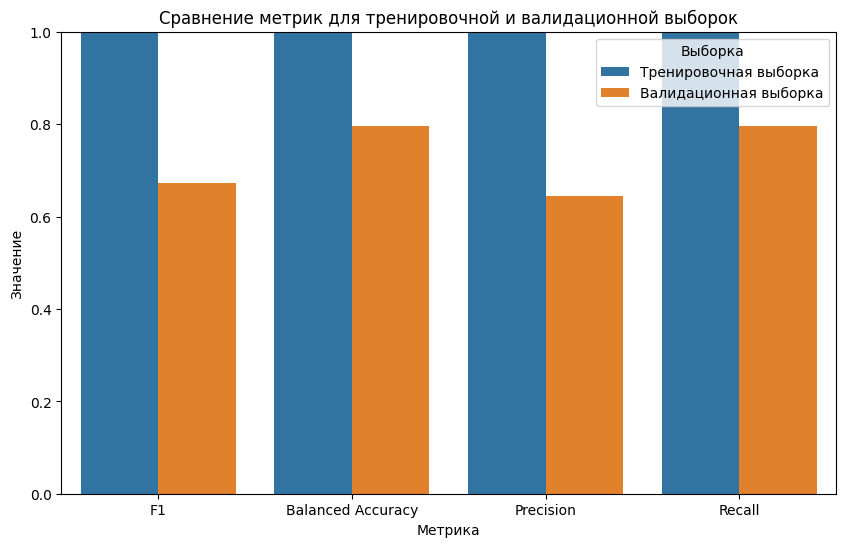

In [98]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## 3. Улучшение бейзлайна

### Препроцессинг данных

In [99]:
df_optimized = df.copy()

Найден дубликат, удалим его

In [100]:
df_optimized = df_optimized.drop_duplicates()

In [101]:
# Обработка выбросов
def remove_outliers(data, columns, threshold=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df_optimized = remove_outliers(df_optimized, df_optimized.columns)

In [102]:
X = df_optimized.drop(target_column, axis=1)
y = df_optimized[target_column]

Скалирование данных

In [103]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Балансировка классов

In [104]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [105]:
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
    )


Решим проблему высокой корреляции данных

In [106]:
pca = PCA(n_components=new_X_train.shape[1])
pca.fit(new_X_train)

PCA(n_components=9)

Проверим сколько компонент дают 90% дисперсии

In [107]:
pca.explained_variance_ratio_.round(2)

array([0.27, 0.23, 0.15, 0.13, 0.1 , 0.06, 0.05, 0.  , 0.  ])

Достаточно 7-и компонент

### Обучение модели с новыми данными

Переопределим модель

In [108]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", DecisionTreeClassifier())
))

In [109]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model', DecisionTreeClassifier())])

Сделаем предсказания

In [110]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### Оценка качетсва модели с улучшеным бейзлайном

In [111]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [112]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,1.0,0.863158
1,Balanced Accuracy,1.0,0.862963
2,Precision,1.0,0.872054
3,Recall,1.0,0.862963


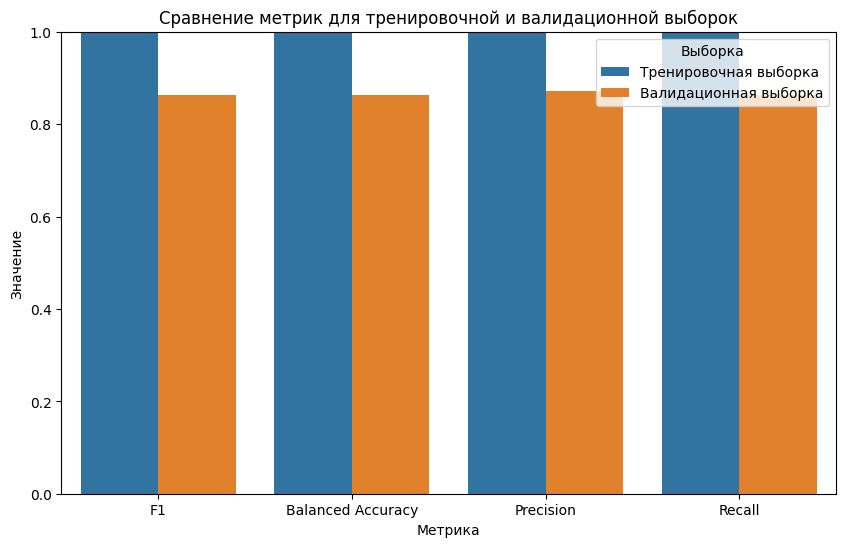

In [113]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Резюме:
На качество модели повлияли, как входные данные, так и параметры самой модели:
- При помощи квантилей я удалил выбросы
- Скалировал данные StandartScaller'ом
- Избавился от дисбалана классов
- Избавился от высокой кореляции фичей

## 4. Имплементация алгоритма машинного обучения

### Реализация модели

In [114]:
class Node:
    def __init__(self, threshold=None, idx_feature=None, criterion=None, parent=None, left_children=None, right_children=None, y_values=None):
        self.threshold = threshold
        self.idx_feature = idx_feature
        self.parent = parent
        self.left_children = left_children
        self.right_children = right_children
        self.y_values = y_values
        self.criterion = criterion

class DecisionTree:
    def __init__(self, max_depth=1000, min_leaf_split=2):
        self.root = None
        self.max_depth = max_depth
        self.min_leaf_split = min_leaf_split

    def fit(self, X, y):
        X, y = self._prepare_inputs(X, y)
        self.root = self.build_tree(X, y)

    def build_tree(self, X, y, parent=None, depth=0):
        if X.shape[0] <= self.min_leaf_split or depth >= self.max_depth:
            return Node(parent=parent, y_values=y)

        best_criterion, best_idx_feature, best_threshold = self.find_best_feature_split(X, y)

        if best_criterion is None or best_criterion <= 0:
            return Node(parent=parent, y_values=y)

        node = Node(threshold=best_threshold, idx_feature=best_idx_feature, criterion=best_criterion, parent=parent, y_values=y)

        left_mask = X[:, best_idx_feature] <= best_threshold
        right_mask = ~left_mask
        left_X, left_y = X[left_mask], y[left_mask]
        right_X, right_y = X[right_mask], y[right_mask]

        node.left_children = self.build_tree(left_X, left_y, parent=node, depth=depth + 1)
        node.right_children = self.build_tree(right_X, right_y, parent=node, depth=depth + 1)

        return node

    def predict(self, X) -> np.ndarray:
        X = self._prepare_inputs(X)
        def traverse_batch(node, X_batch):
            if node.left_children is None and node.right_children is None:
                return np.full(X_batch.shape[0], self._predict_leaf(node), dtype=float)

            left_mask = X_batch[:, node.idx_feature] <= node.threshold
            right_mask = ~left_mask

            predictions = np.empty(X_batch.shape[0], dtype=float)
            if left_mask.any():
                predictions[left_mask] = traverse_batch(node.left_children, X_batch[left_mask])
            if right_mask.any():
                predictions[right_mask] = traverse_batch(node.right_children, X_batch[right_mask])
            return predictions

        return traverse_batch(self.root, X)


    def find_best_feature_split(self, X: np.ndarray, y: np.ndarray):
        best_idx_feature = None
        best_threshold = None
        best_criterion = 0

        for idx_feature in range(X.shape[1]):
            cur_criterion, cur_threshold = self.find_best_threshold_split(X[:, idx_feature], y)
            if cur_criterion > best_criterion:
                best_threshold = cur_threshold
                best_criterion = cur_criterion
                best_idx_feature = idx_feature

        return best_criterion, best_idx_feature, best_threshold

    def find_best_threshold_split(self, X_cols: np.ndarray, y: np.ndarray):
        best_criterion = 0
        best_threshold = None

        uniq_elem = np.unique(X_cols)
        for i in range(1, len(uniq_elem)):
            threshold = (uniq_elem[i-1] + uniq_elem[i]) / 2
            y_left, y_right = self.get_split(X_cols, y, threshold)
            cur_criterion = self.calculate_criterion(y, y_left, y_right)
            if cur_criterion > best_criterion:
                best_criterion = cur_criterion
                best_threshold = threshold

        return best_criterion, best_threshold

    def calculate_criterion(self, y: np.ndarray, y_left: np.ndarray, y_right: np.ndarray):
        total_len = len(y)
        len_left = len(y_left)
        len_right = len(y_right)

        if len_left == 0 or len_right == 0:
            return 0.0

        return (
            self.criterion(y)
            - (len_left / total_len * self.criterion(y_left)
            + len_right / total_len * self.criterion(y_right))
        )

    @staticmethod
    def get_split(X_cols, y, threshold):
        indices = X_cols <= threshold
        left = y[indices]
        right = y[~indices]
        return left, right

    @staticmethod
    def _prepare_inputs(X, y=None):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        X = X.astype(float)

        if y is not None:
            if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
                y = y.values
            if isinstance(y, list):
                y = np.array(y)
            if isinstance(y, pd.CategoricalDtype):
                y = y.astype(int)
            y = y.astype(float)
            return X, y

        return X
    
class MyDecisionTreeClassifier(DecisionTree):
    def __init__(self, criterion = "gini", max_depth=10, min_leaf_split=2):
        super().__init__(max_depth, min_leaf_split)
        self.criterion = self.calculate_gini
        if criterion == "entropy":
            self.criterion = self.calculate_entropy

    def _predict_leaf(self, node: Node):
        """
        Предсказание для листового узла.
        Возвращает класс, который чаще всего встречается в y_values узла.
        """
        unique, counts = np.unique(node.y_values, return_counts=True)
        return unique[np.argmax(counts)]

    @staticmethod
    def calculate_gini(y: np.ndarray):
        sum_counts = len(y)
        _, counts = np.unique(y, return_counts=True)
        p_k = counts / sum_counts
        return 1 - np.sum(p_k * p_k).item()

    @staticmethod
    def calculate_entropy(y: np.ndarray):
        sum_counts = len(y)
        _, counts = np.unique(y, return_counts=True)
        p_k = counts / sum_counts
        log_p_k = np.where(p_k > 0, np.log(p_k) / np.log(2), 0.0)
        return - np.sum(p_k * log_p_k).item()


### Обучение 

In [115]:
model = MyDecisionTreeClassifier()
model.fit(X_train, y_train)

In [116]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

###  Оценка качества модели

In [117]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro', zero_division=1)

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro', zero_division=1)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [118]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.966291,0.686615
1,Balanced Accuracy,0.949545,0.763492
2,Precision,0.986149,0.702015
3,Recall,0.949545,0.763492


Визуализация

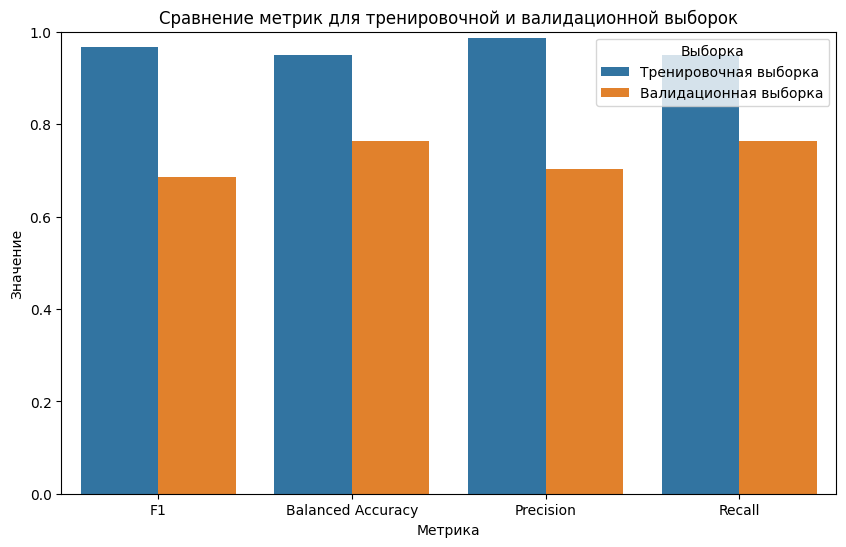

In [119]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучение с улучшенным бейзлайном

In [120]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", MyDecisionTreeClassifier())
))

In [121]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model',
                 <__main__.MyDecisionTreeClassifier object at 0x000001623EC22310>)])

In [122]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

###  Оценка качества модели

In [123]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [124]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.982564,0.897800
1,Balanced Accuracy,0.982456,0.900000
2,Precision,0.982895,0.916667
3,Recall,0.982456,0.900000


Визуализация

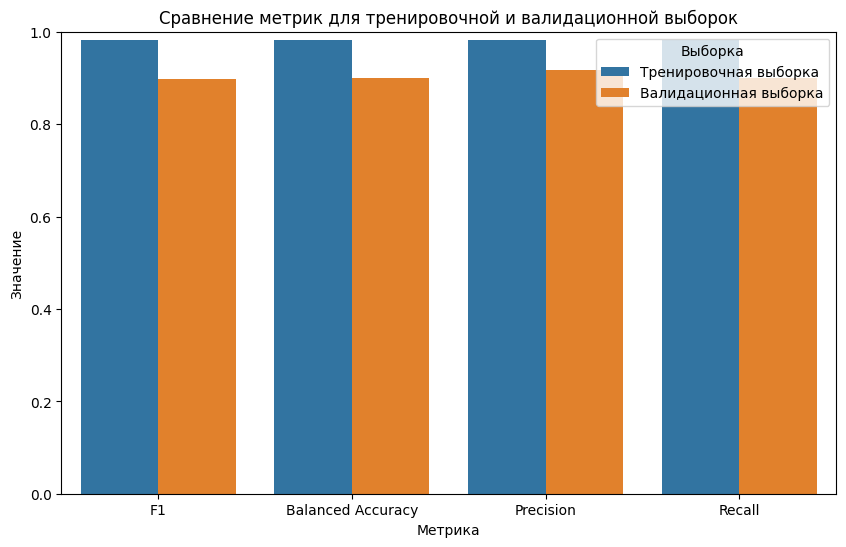

In [125]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()